# Решение домашнего задания #6

В этой задаче будет использована только библиотечная реализация для достижения наилучшей производительности (иначе в архитектуре нет никакого смысла =ъ)

### Базовая настройка

In [1]:
import torch
from torch.utils.data import DataLoader
from xlstm import xLSTMLMModel, xLSTMLMModelConfig, mLSTMBlockConfig, sLSTMBlockConfig, mLSTMLayerConfig, sLSTMLayerConfig

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

import pandas as pd

from matplotlib import pyplot as plt


from torch.nn.functional import cross_entropy, softmax
import seaborn as sns

/home/setday/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
TARGET_ROW = "To prove that"

In [4]:
config = xLSTMLMModelConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=12,
            num_heads=8,
        ),
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            conv1d_kernel_size=12,
            num_heads=8,
        ),
    ),
    context_length=128,
    num_blocks=12,
    embedding_dim=64,
    slstm_at=[0, 2, 3, 5, 6, 8, 9, 11],
    vocab_size=50304,
)

### Загрузка датасета (датасет латеховских статей) и токенайзера (токенайзер GPT-2)

In [5]:
train_ds = pd.concat([pd.read_parquet(f'../../data/proof-pile/000{i}.parquet') for i in range(3)], ignore_index=True)
text_data = train_ds['text'].tolist()

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

1

### Теперь нам нужен кастомный лоадер для тренировки

In [7]:
class CustomLoader(DataLoader):
    def __init__(self, texts, tokenizer, loader_size=16, batch_size=16, block_size=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.block_size = block_size
        self.loader_size = loader_size

        self.text_id = -self.loader_size
        self.page_tokens = None
        self.page_training_pairs = None

        self.next_page()

        super().__init__(self, batch_size=batch_size)

    def next_page(self):
        self.text_id += self.loader_size
        if self.text_id + self.loader_size > len(self.texts):
            self.text_id = 0
        self.page_tokens = [
            self.tokenizer.encode(self.texts[self.text_id + i])
            for i in range(self.loader_size)
        ]
        self.page_training_pairs = torch.tensor([
            [
                tokens[i:i + self.block_size],
                tokens[i + 1:i + self.block_size + 1]
            ]
            for tokens in self.page_tokens
            for i in range(0, len(tokens) - self.block_size)
        ])
        self.page_training_pairs = self.page_training_pairs[torch.randperm(len(self.page_training_pairs))]

    def __iter__(self):
        for i in range(0, len(self.page_training_pairs), self.batch_size * 30):
            yield self.page_training_pairs[i:i + self.batch_size, 0, :], self.page_training_pairs[i:i + self.batch_size, 1, :]

    def __len__(self):
        return len(self.page_training_pairs) // self.batch_size // 30

### Теперь мы готовы к обучению

In [8]:
dl = CustomLoader(text_data, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (7399 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
class LightningXLSTM(LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.model = xLSTMLMModel(config)
        self.tokenizer = tokenizer
        self._context_length = config.context_length

        self.loss_history = []

    def forward(self, idx):
        return self.model(idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        idx, targets = batch
        logits = self.model(idx)
        loss = cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.loss_history.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        token_lim=10
        use_top_k=10
        temperature=1.0

        idx = self.tokenizer.encode(TARGET_ROW, return_tensors='pt').to(self.device)
        state=None

        for i in range(idx.shape[1] - 1):
            _, state = self.model.step(idx[:, i].unsqueeze(1), state)

        for _ in range(token_lim):
            logits, state = self.model.step(idx[:, -1].unsqueeze(1), state)
            logits = logits[:, -1, :] / temperature
            v, _ = torch.topk(logits, min(use_top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
            probs = softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        generated_text = self.tokenizer.decode(idx[0], skip_special_tokens=True)
        print('test/generated_text', generated_text)
        
        return super().on_train_epoch_start()
    
    def on_train_epoch_end(self):
        dl.next_page()

        return super().on_train_epoch_end()

In [10]:
model = LightningXLSTM(config, tokenizer)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/setday/.cache/torch_extensions/py310_cu128/slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/setday/.local/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


ninja: no work to do.


/home/setday/.local/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/setday/.local/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/setday/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-

Using /home/setday/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


In [11]:
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | xLSTMLMModel | 6.8 M  | train
-----------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.262    Total estimated model params size (MB)
219       Modules in train mode
0         Modules in eval mode
/home/setday/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=5.580, train/loss_epoch=7.590]          test/generated_text To prove that}$$ the$
_s^{t
Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=4.110, train/loss_epoch=5.240]          test/generated_text To prove that $X$
$ and $G$ is
Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=4.050, train/loss_epoch=4.120]          test/generated_text To prove that the following of the second.
\begin{
Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=3.610, train/loss_epoch=4.040]          test/generated_text To prove that $Q_1$. This are the


Epoch 9: 100%|██████████| 250/250 [00:31<00:00,  7.86it/s, train/loss_step=3.910, train/loss_epoch=4.170]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:34<00:00,  7.31it/s, train/loss_step=3.910, train/loss_epoch=4.170]


<Axes: >

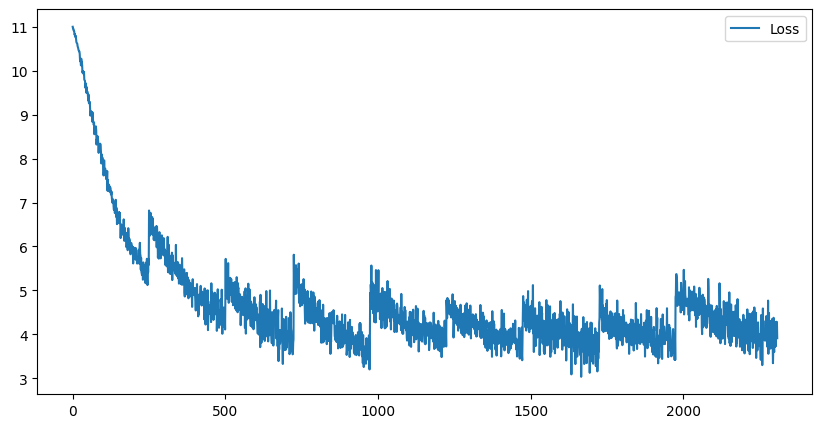

In [12]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Loss')

### Смотрим, что же получилось

_предварительно откатываем модель до 3-ей эпохи_

In [13]:
token_lim=300
use_top_k=10
temperature=1.0

idx = tokenizer.encode(TARGET_ROW, return_tensors='pt').to(device='cuda')
state=None

model.model = model.model.to(device='cuda')

for i in range(idx.shape[1] - 1):
    _, state = model.model.step(idx[:, i].unsqueeze(1), state)

for _ in range(token_lim):
    logits, state = model.model.step(idx[:, -1].unsqueeze(1), state)
    logits = logits[:, -1, :] / temperature
    v, _ = torch.topk(logits, min(use_top_k, logits.size(-1)))
    logits[logits < v[:, [-1]]] = -float('Inf')
    probs = softmax(logits, dim=-1)
    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)

generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print('test/generated_text', generated_text)

test/generated_text To prove that the the following the of $\nf{1:d}_{i}\label{M1}{\mathbb{R}_{k+1,\infty}$ and $\bar[\mathbf{1}^\mathbf{2}}$ such that $\hat{C}(\tilde{\hat{x}^1}$ and
\begin{lemma}{2} 
&\mathcal{B_2}\alpha_0$ is a
\begin{align}
\mathbf{S}
              0.1.5 \in\mathbf{L}_{2}^{-1},\frac{2}{2}
\end{equation}
where
\begin{proof}

\end{equation}


\end{proof}
\begin{align*}
\label{eq:f}
\end{align}
\label{eq:L-1}{q:6}
\item\{\textbf{x}_{\d\alpha$, $\mathf{\}$ for $t_2$ be the same
\label{eq:def:3}
\end{proof}
\label{eq:Lref{eq:eq:d2} ~\ref{eq,i:0,2}}$ is


In [26]:
def plot_weights(heads, title='Attention Weights'):
    fig, ax = plt.subplots(4, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i, matrix in enumerate(heads):
        sns.heatmap(matrix, ax=ax[i // 4][i % 4], square=True)
        ax[i // 4][i % 4].set_title(f'Head {i + 1}')
        ax[i // 4][i % 4].axis('off')

    plt.tight_layout()
    plt.show()

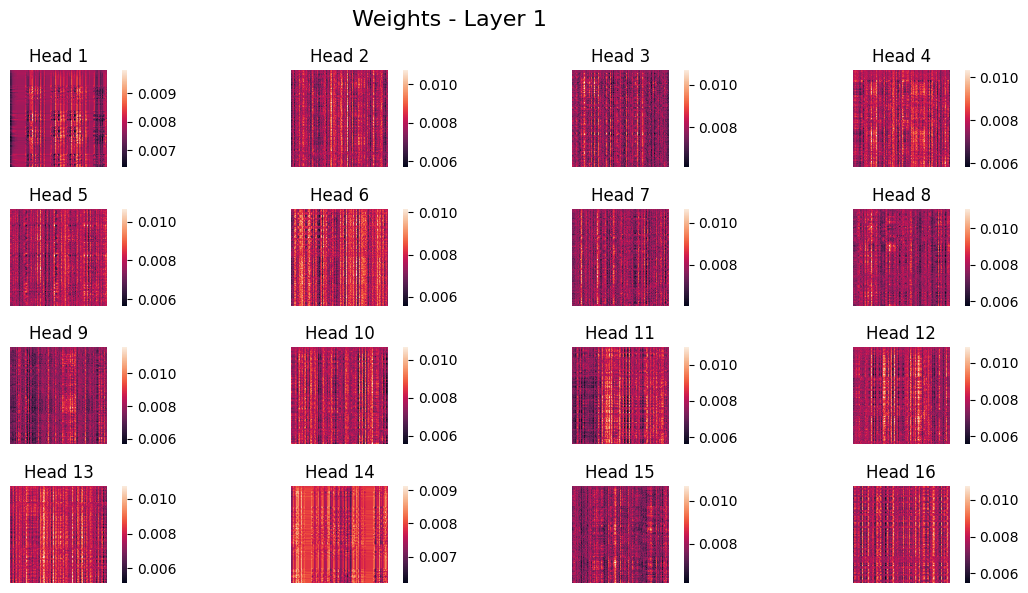

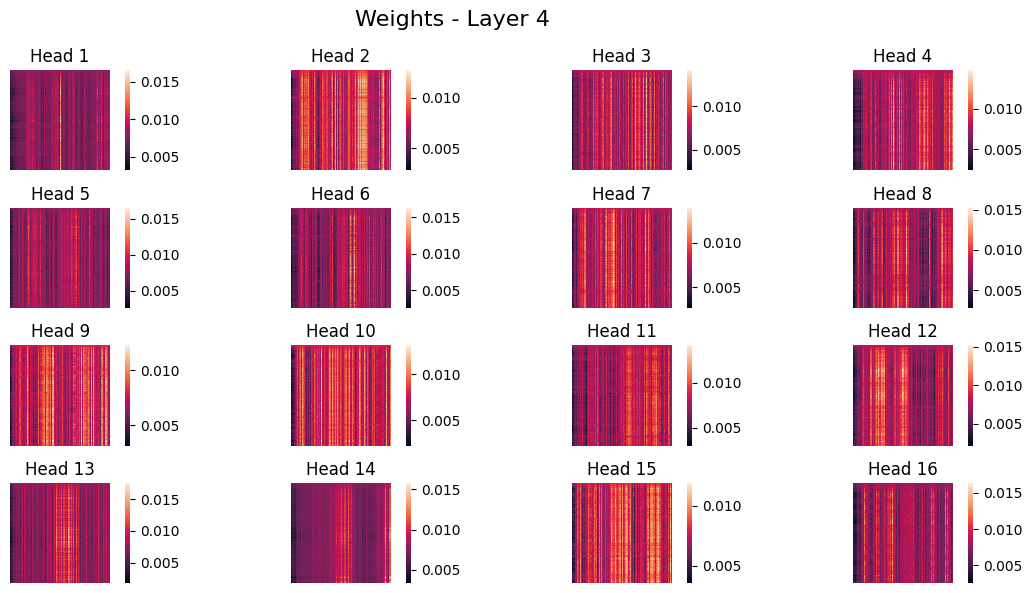

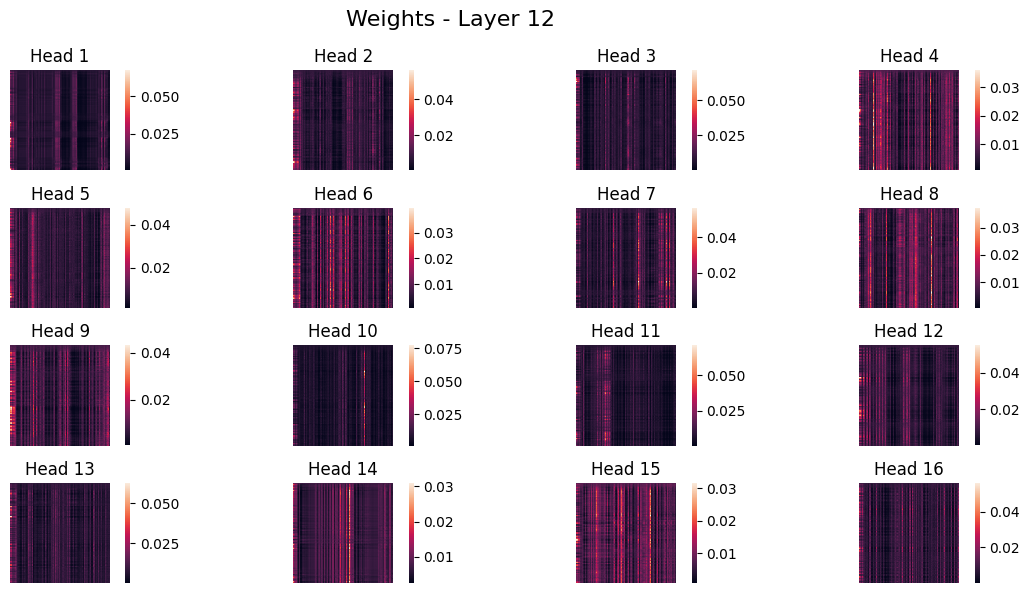

In [27]:
plot_weights(model.model.xlstm_block_stack.blocks[1].xlstm.saved_attention_weights, title='Weights - Layer 1')
plot_weights(model.model.xlstm_block_stack.blocks[4].xlstm.saved_attention_weights, title='Weights - Layer 4')
plot_weights(model.model.xlstm_block_stack.blocks[7].xlstm.saved_attention_weights, title='Weights - Layer 12')

# Итоги

1. В сравнении с `Mamba`, `xLSTM` ведет себя более стабильно на котортких дистанциях, однако чем больше токенов она генерирует, тем сильнее расходимость (это довольно просто описать тем, что модель не обучена хорошо держаться на длинных последовательностях; можно увеличить контекстное окно, однако это немного замедлит модель, но только на этапе преподсчета состояния).
2. Веса также интерпретировать практически невозможно. Хотя явно заметно, что модель смотрит на токены по "полосам".